In [18]:
# imports
import pathlib
import os
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [4]:
current_dir = pathlib.Path(os.getcwd())
model_dir = current_dir / "models"

In [5]:
ihuman = cobra.io.read_sbml_model(model_dir / "Human-GEM.xml")
A375_ftINIT = cobra.io.read_sbml_model(model_dir / "A375_ftINIT_model_prep.xml")
A375_sMOMENT = cobra.io.read_sbml_model(model_dir / "A375_sMOMENT_model.xml")

In [6]:
models = {
    "ihuman": ihuman,
    "A375_ftINIT": A375_ftINIT,
    "A375_sMOMENT": A375_sMOMENT
}

In [7]:
models_growth = {}
for name, model in models.items():
    models_growth[name] = model.slim_optimize()
print(models_growth)

{'ihuman': 124.86814837744573, 'A375_ftINIT': 124.82912844999419, 'A375_sMOMENT': 0.4753331467433929}


In [9]:
# performing FBA on all models
FBA_solutions = {}
for model_name, model in models.items():
    FBA_solutions[model_name] = model.optimize()

In [ ]:
models_pathway_fluxes = {}
for model_name in models.keys():
    models_pathway_fluxes[model_name] = []

pathway_list = []
for pathway in models["ihuman"].groups:
    pathway_list.append(pathway.name)

for model_name in models.keys():
    for pathway in models["ihuman"].groups:
        pathway_flux = 0
        for rxn in pathway.members:
            if rxn in models[model_name].reactions:
                pathway_flux += FBA_solutions[model_name].fluxes[rxn.id]
        models_pathway_fluxes[model_name].append(pathway_flux)

pathway_fluxes_df = pd.DataFrame(models_pathway_fluxes, index=pathway_list)
pathway_fluxes_df

,ihuman,A375_ftINIT,A375_sMOMENT
Arachidonic acid metabolism,0.000000,0.000000,0.000000
Acyl-CoA hydrolysis,5.818161,3.706971,0.000000
Acylglycerides metabolism,2.830781,99.990457,0.000039
"Alanine, aspartate and glutamate metabolism",841.270087,99.786832,0.000000
Alkaloids biosynthesis,0.000000,0.000000,0.000000
...,...,...,...
Vitamin C metabolism,0.000000,0.000000,0.000000
Vitamin D metabolism,0.036082,0.036071,0.000147
Vitamin E metabolism,458.619858,0.067183,0.000276
Xenobiotics metabolism,0.000000,0.000000,0.000000


In [24]:
print(pathway_fluxes_df)

                                                 ihuman  A375_ftINIT  \
 Arachidonic acid metabolism                   0.000000     0.000000   
Acyl-CoA hydrolysis                            5.818161     3.706971   
Acylglycerides metabolism                      2.830781    99.990457   
Alanine, aspartate and glutamate metabolism  841.270087    99.786832   
Alkaloids biosynthesis                         0.000000     0.000000   
...                                                 ...          ...   
Vitamin C metabolism                           0.000000     0.000000   
Vitamin D metabolism                           0.036082     0.036071   
Vitamin E metabolism                         458.619858     0.067183   
Xenobiotics metabolism                         0.000000     0.000000   
octane oxidation                               0.000000     0.000000   

                                             A375_sMOMENT  
 Arachidonic acid metabolism                     0.000000  
Acyl-CoA hydrol

In [19]:
# Defining a function to draw heatmaps

def heatmap(data, x_label, y_label, factor_label: str, x_fontsize: int=10, y_fontsize: int=8, fontfamily="Bahnschrift", colortype: str='plasma', shrinkfct: float=0.1, figuresize: tuple=(22, 22), symmetric_scale: bool=False, abs_max=None, save_as: str=None):
    """
    colortype: Colorscale of the colormap
        Perceptually Uniform Sequential:
        - viridis (default)
        - plasma
        - inferno
        - magma
        - cividis (colorblind-friendly)
        Non-Uniform Sequential:
        - Greys
        - Purples
        - Blues
        - Oranges
        - Reds
        - Greens
        Diverging:
        - coolwarm
        - seismic
        - Spectral
        - PiYG (Pink-Green)
        - PRGn (Purple-Green)
        - RdBu (Red-Blue)
        - RdGy (Red-Grey)
        - BrBG (Brown-BlueGreen)
        Qualitative:
        - tab10 (default for discrete categories)
        - Set1, Set2, Set3
        - Accent
        - Dark2
        - Paired
        - Pastel1, Pastel2
        Cyclic:
        - twilight
        - twilight_shifted
        - hsv
        Miscellaneous Colormaps
        - jet (legacy, not recommended for scientific work due to perceptual issues)
        - rainbow (colorful but not perceptually uniform)
        - flag
        - gist_rainbow
        A _r following a colortype inverts the colors
    """

    # Determine the normalization for the colormap
    if symmetric_scale:
        if abs_max is None:
            abs_max = max(abs(data.min()), abs(data.max()))  # Use the maximum absolute value in the data
        norm = Normalize(vmin=-abs_max, vmax=abs_max)  # Symmetric normalization
    else:
        norm = None  # Default normalization

    # Plot the heatmap
    plt.figure(figsize=figuresize)  # Adjust figure size for square heat fields
    ax = plt.gca()  # Get the current axis
    heatmap = ax.imshow(data, cmap=colortype, aspect='equal', interpolation='nearest', norm=norm)  # aspect='equal' ensures square fields

    # Add color bar with adjusted thickness
    cbar = plt.colorbar(heatmap, shrink=shrinkfct)  # Shrink reduces the size of the color bar
    cbar.set_label(factor_label, rotation=270, labelpad=20)

    # Set axis labels
    ax.set_xticks(np.arange(len(x_label)))
    ax.set_xticklabels(x_label, rotation=90, fontsize=x_fontsize, fontfamily=fontfamily)  # Smaller font size for x labels
    ax.xaxis.tick_top()  # Move x-axis labels to the top

    # Show all y-axis labels with smaller font size
    ax.set_yticks(np.arange(len(y_label)))
    ax.set_yticklabels(y_label, fontsize=y_fontsize, fontfamily=fontfamily)  # Reduced font size for y labels

    # Remove the title
    plt.tight_layout()

    # Save he plot
    if save_as != None:
        plt.savefig(save_as, dpi=300, transparent=True, bbox_inches='tight')

    # Show the plot
    plt.show()

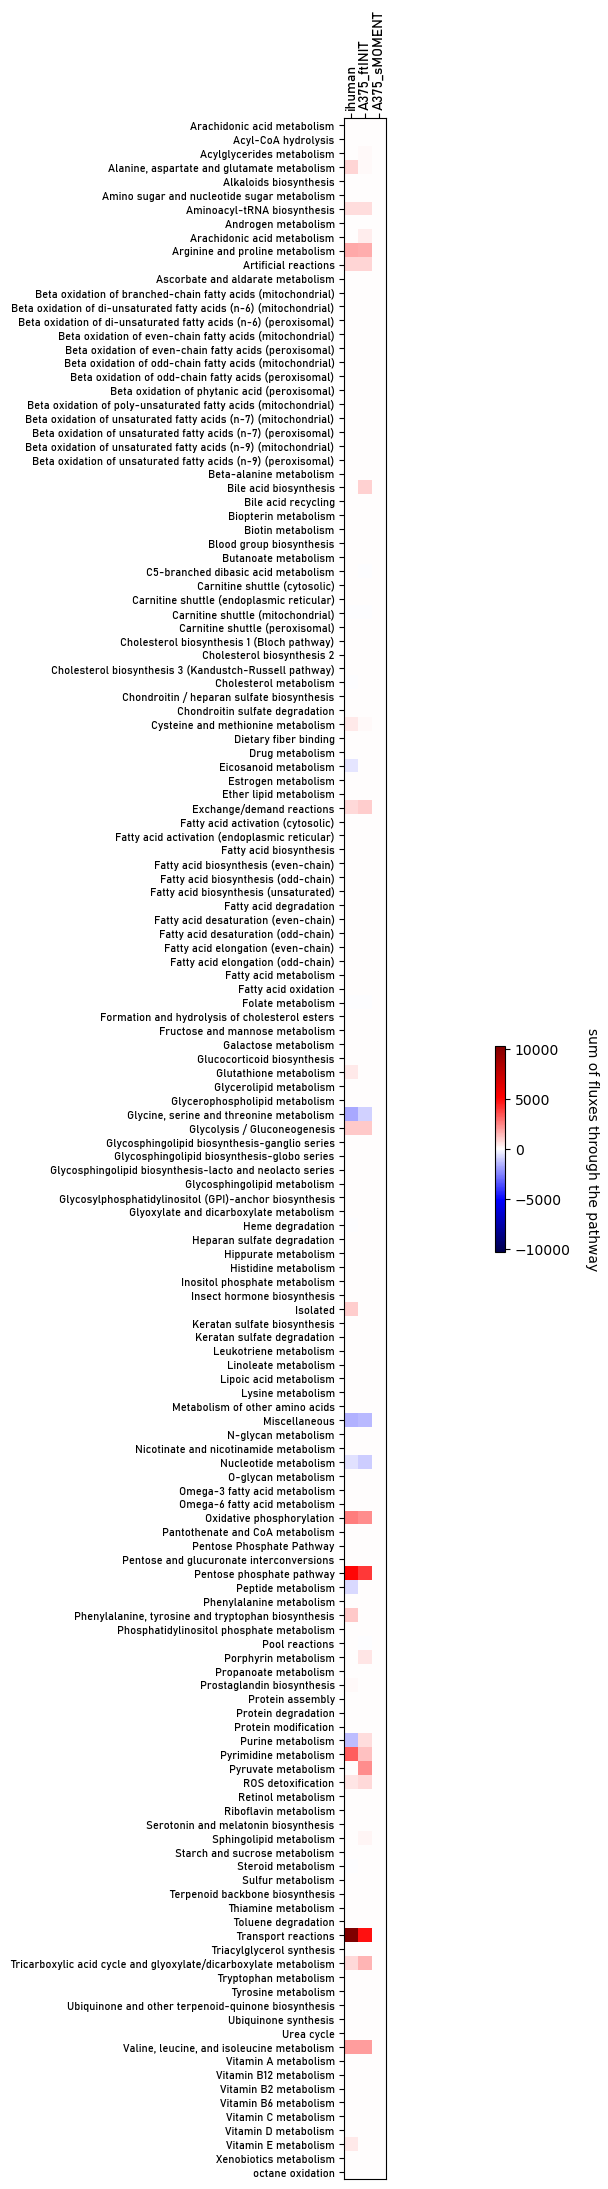

In [23]:
# visualizing the fluxes as a heatmap
heatmap(pathway_fluxes_df.to_numpy(), models.keys(), pathway_list, 'sum of fluxes through the pathway', symmetric_scale=True, colortype="seismic")